In [1]:
import random
from data import  TextField, RawField
from caption_model.transformer import Transformer
import torch 
import os, pickle,sys
import numpy as np
import itertools
from torch import nn
import multiprocessing
from shutil import copyfile
import warnings


from load_model_3layers import load_capModel
import re 
import requests
import json
from PIL import Image
import matplotlib.pyplot as plt
random.seed(1234)
torch.manual_seed(1234)
np.random.seed(1234)

from detection import proposals,detection_detr 
import sys 


detectionModel=detection_detr.load_detr() # 


Using cache found in /home/shikha/.cache/torch/hub/facebookresearch_detr_master


In [2]:
class Args():
    def __init__(self):
        self.device=torch.device('cuda:0')
        self.exp_name='LATGeO_transformer'
        self.batch_size=10
        self.workers=1
        self.m=40
        self.head=8
        self.label_file='./data/objects_vocab.txt'
        self.load_weight='./trained_models/rcnn_31_epoch.pth'
        self.detection='rcnn'
args=Args()

In [3]:
device = torch.device('cuda:0')
## 

print('LATGeO Image Captioning Testing')
text_field = TextField(init_token='<bos>', eos_token='<eos>', lower=True, tokenize='spacy',
                           remove_punctuation=True, nopoints=False)
text_field.vocab = pickle.load(open('vocab_%s.pkl' % args.exp_name, 'rb'))

model=load_capModel(args,text_field,device)
model.eval()



LATGeO Image Captioning Testing
Loading from epoch 31, validation loss 5.625735, and best cider 1.308922


Transformer(
  (encoder): MemoryAugmentedEncoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (mhatt): MultiHeadAttention(
          (attention): GeomtericAttention(
            (fc_q): Linear(in_features=512, out_features=512, bias=True)
            (fc_k): Linear(in_features=512, out_features=512, bias=True)
            (fc_v): Linear(in_features=512, out_features=512, bias=True)
            (fc_o): Linear(in_features=512, out_features=512, bias=True)
            (fc_g): Linear(in_features=64, out_features=1, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (dropout_2): Dropout(p=0.1, inplace=False)
          (layer_no

In [4]:
def predict_caption(file_url,beam_size=1,show_objs=False):
    load_online=False
    if file_url.startswith('http'):
        im = Image.open(requests.get(file_url, stream=True).raw)
        im.save('./temp.jpg')
        file_url='./temp.jpg'
        load_online=True
    objs,bbox,probs,labels,im=proposals.process_image(file_url,detectionModel,text_field,args,50,device,show_objs)
    out, _ =model.beam_search(objs.to(device),bbox.to(device)
                     ,labels.to(device),probs.to(device),
                     20, text_field.vocab.stoi['<eos>'],beam_size, out_size=1)
    caps_gen = text_field.decode(out, join_words=False)
    if show_objs==False:
        plt.imshow(im)
    if load_online:
        os.remove(file_url)
    return " ".join(caps_gen[0])

In [5]:
imgUrl='./sample_images/COCO_test2014_000000000245.jpg' #path to your image
#objs,bbox,probs,labels,im=proposals.process_image(imgUrl,detectionModel,text_field,args,50,device,True)  #if you would like to show the proposals as well

/home/shikha/.conda/envs/mlp3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


'a woman walking on the beach with an umbrella on      '

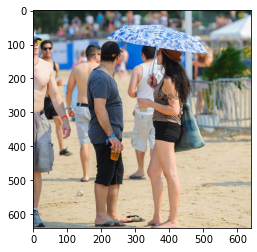

In [6]:

predict_caption(imgUrl,1,False)   #when the beam size is 1 and shwoing the proposal along with the caption

'a man and a woman walking on the beach with an umbrella  '

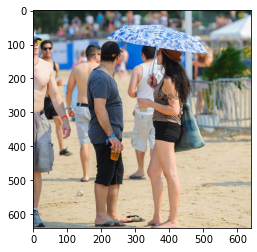

In [7]:
predict_caption(imgUrl,5,False)   #when the beam size is 5 and shwoing the proposal along with the caption

In [8]:
imgUrl='./sample_images/COCO_test2014_000000002219.jpg' #path to your image
#objs,bbox,probs,labels,im=proposals.process_image(imgUrl,detectionModel,text_field,args,50,device,True)  #if you would like to show the proposals as well


'a yellow and blue train is at a train station      '

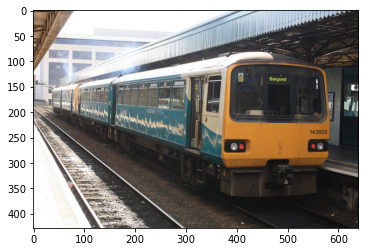

In [9]:

predict_caption(imgUrl,1,False)   #when the beam size is 1 and shwoing the proposal along with the caption

'a yellow and blue train at a train station  '

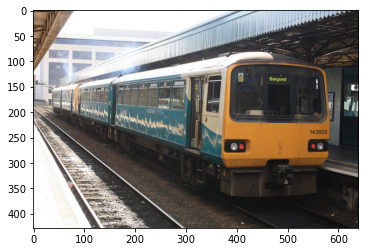

In [10]:
predict_caption(imgUrl,20,False)    #when the beam size is 1 and not shwoing the proposal along with the caption

'a man riding a white motorcycle down a road  '

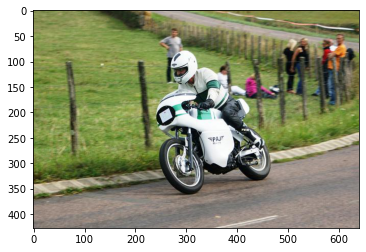

In [11]:
tempUrl='http://images.cocodataset.org/val2017/000000007816.jpg'
predict_caption(tempUrl,5,False)   ##passing online image url

'two elephants standing next to a water hole          '

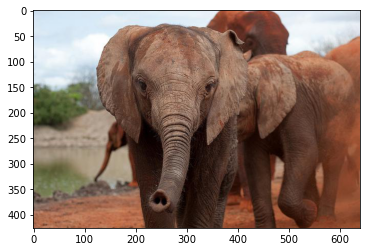

In [12]:
tempUrl='http://images.cocodataset.org/val2017/000000007108.jpg'
predict_caption(tempUrl,1,False)   ##passing online image url